In [9]:
import pandas as pd
import h5py
import os
import numpy as np
from selenobot.datasets import Dataset, get_dataloader
# from scipy.stats import f_oneway, kstest
# import scipy
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from selenobot.classifiers import *
import scipy.stats
from typing import List, Tuple, Dict, NoReturn
from tqdm import tqdm
from selenobot.files import *
from sklearn.metrics import balanced_accuracy_score
from scipy.stats import kstest, mannwhitneyu
from fabapi import Query

%load_ext autoreload
%autoreload 2

# Define some important directories...
ROOT_DIR = '..'
RESULTS_DIR = os.path.join(ROOT_DIR, 'results') # Get the path where results are stored.
MODELS_DIR = os.path.join(ROOT_DIR, 'models')
DATA_DIR = os.path.join(ROOT_DIR, 'data') # Get the path where results are stored. 
SCRIPTS_DIR = os.path.join(ROOT_DIR, 'scripts') # Get the path where results are stored.



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
x = NcbiXmlFile(os.path.join(DATA_DIR, 'uniprot_sprot_test.xml'))

NcbiXmlFile.__init__: Read in NCBI XML file at path ../data/uniprot_sprot_test.xml.


NcbiXmlFile.__init__: Parsing NCBI XML file...: 100%|██████████| 3/3 [00:00<00:00, 2223.52it/s]


In [11]:
x.dataframe()

,domain,kingdom,phylum,class,order,family,species,ncbi_taxonomy_id,refseq_protein_id,refseq_nucleotide_id,seq,name
gene_id,,,,,,,,,,,,
Q9V2L2,Archaea,Euryarchaeota,Thermococci,Thermococcales,Thermococcaceae,Pyrococcus,Pyrococcus abyssi (strain GE5 / Orsay),272844,WP_010867187.1,NC_000868.1,MHPKVDALLSRFPRITLIPWETPIQYLPRISRELGVDVYVKRDDLT...,1A1D_PYRAB
G8ZFP4,Archaea,Euryarchaeota,Thermococci,Thermococcales,Thermococcaceae,Pyrococcus,Pyrococcus abyssi (strain GE5 / Orsay),272844,WP_010867187.1,NC_000868.1,MHPKVDALLSRFPRITLIPWETPIQYLPRISRELGVDVYVKRDDLT...,1A1D_PYRAB
Q8U4R3,Archaea,Euryarchaeota,Thermococci,Thermococcales,Thermococcaceae,Pyrococcus,Pyrococcus furiosus (strain ATCC 43587 / DSM 3...,186497,WP_011011122.1,NZ_CP023154.1,MHPKVQSLLSKFPRVELIPWETPIQYLPNISKLVGADIYVKRDDLT...,1A1D_PYRFU
O57809,Archaea,Euryarchaeota,Thermococci,Thermococcales,Thermococcaceae,Pyrococcus,Pyrococcus horikoshii (strain ATCC 700860 / DS...,70601,WP_010884169.1,NC_000961.1,MHPKIFALLAKFPRVELIPWETPIQYLPNISREIGADVYIKRDDLT...,1A1D_PYRHO


In [35]:
x.dataframe().to_csv('../data/uniprot_sprot_archaea.csv')

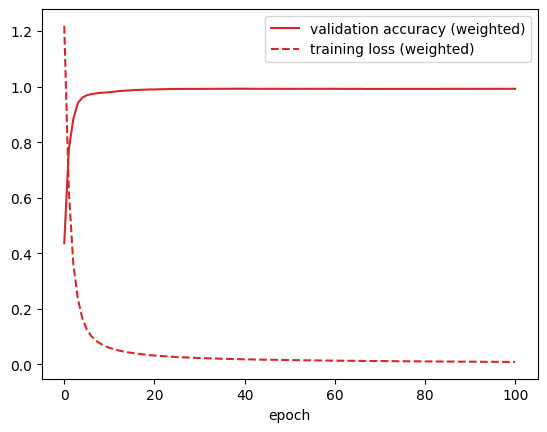

In [12]:
model = Classifier.load(os.path.join(MODELS_DIR, 'model_epochs_100_lr_e8.pkl'))
model_bb = Classifier.load(os.path.join(MODELS_DIR, 'model_epochs_100_lr_e8_balance_batches.pkl'))
model_bb = Classifier.load(os.path.join(MODELS_DIR, 'model_epochs_100_lr_e8_balance_batches.pkl'))


fig, ax = plt.subplots()
# ax.plot(np.arange(len(model.val_accs)), model.val_accs, c='tab:blue')
# ax.plot(np.arange(len(model.train_losses)), model.train_losses, c='tab:blue', ls='--')
ax.plot(np.arange(len(model_bb.val_accs)), model_bb.val_accs, c='tab:red')
ax.plot(np.arange(len(model_bb.train_losses)), model_bb.train_losses, c='tab:red', ls='--')

ax.set_xlabel('epoch')

ax.legend(['validation accuracy (weighted)', 'training loss (weighted)', 'validation accuracy (balance batches)', 'training loss (balance batches)',])
plt.show()

# print('Best validation accuracy:', model.val_accs[model.best_epoch])
# print('Best epoch:', model.best_epoch)

In [4]:
model_bb.best_epoch

9

In [5]:
test_dataset = Dataset(pd.read_csv(os.path.join(DATA_DIR, 'test.csv')).set_index('gene_id'))
test_predictions = model.predict(test_dataset)
test_predictions_bb = model_bb.predict(test_dataset)

print('Test accuracy (weighted):', balanced_accuracy_score(test_dataset.labels, test_predictions))
print('Test accuracy (balance batches):', balanced_accuracy_score(test_dataset.labels, test_predictions_bb))

# For 2000 epochs, learning rate e-8: 0.9943182517917055
# For 1000 epochs, learning rate e-6: 0.9891197858353995
# For 1000 epochs, learning rate e-7: 0.9915394770126511
# For 1000 epochs, learning rate e-8: 0.9939928067866008


Test accuracy (weighted): 0.976602654859541
Test accuracy (balance batches): 0.939390676463425


In [26]:
n = 11617.0
np.log(0.01) / np.log(1 - 1/n)

np.float64(53495.95943250103)

In [30]:
# Want to make sure the balanced batch sampler is working correctly. 
# train_dataset = Dataset(pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('gene_id'))
dataloader = get_dataloader(train_dataset, batch_size=16, balance_batches=True)

get_dataloader: 3359210 samples required for dataset coverage.


In [37]:
print(len(train_dataset))

374775


In [36]:
r0, r1 = [], []
n_batches = len(dataloader)
print(n_batches, 'batches in the DataLoader.')
gene_ids = []

for batch in dataloader:
    batch_labels = batch['label']
    batch_size = len(batch_labels)
    r0.append((batch_size - batch_labels.sum().item()) / batch_size)
    r1.append(batch_labels.sum().item() / batch_size)
    gene_ids.append(batch['gene_id'])

gene_ids = np.unique(np.concatenate(gene_ids).ravel())
print(f'Saw {len(gene_ids)} unique gene IDs.')
print('Average proportion of selenoproteins per batch:', np.mean(r1))
print('Average proportion of non-selenoproteins per batch:', np.mean(r0))


209951 batches in the DataLoader.
Saw 371236 unique gene IDs.
Average proportion of selenoproteins per batch: 0.4996790917880839
Average proportion of non-selenoproteins per batch: 0.5003209082119161


# Dataset exploration

In [4]:
sec_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sec.fa'))
sec_truncated_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sec.fa'))
sprot_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sprot.fa'))

print('Number of selenoproteins:', len(sec_fasta_file))
print('Number of selenoproteins (truncated):', len(sec_truncated_fasta_file))
print('Number of SwissProt sequences:', len(sprot_fasta_file))

Number of selenoproteins: 18988
Number of selenoproteins (truncated): 18988
Number of SwissProt sequences: 569539


In [5]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), usecols=['gene_id'])
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), usecols=['gene_id'])
val_df = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'), usecols=['gene_id'])

print('Size of training data:', len(train_df))
print('Size of testing data:', len(test_df))
print('Size of validation data:', len(val_df))

Size of training data: 374775
Size of testing data: 119485
Size of validation data: 94000


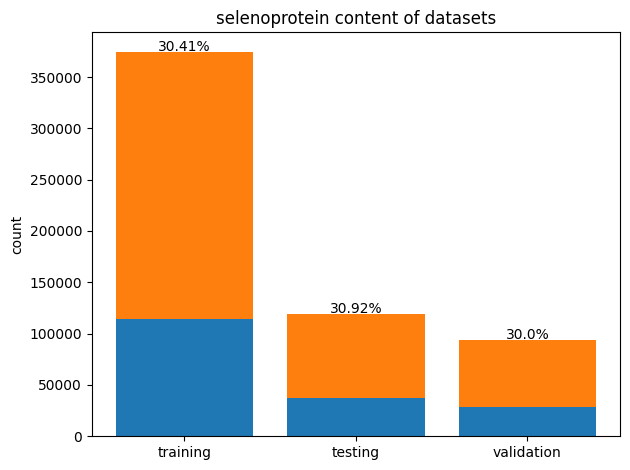

In [6]:
fig, ax = plt.subplots()

sec, non_sec = [], []
for i, df in enumerate([train_df, test_df, val_df]):
    n = np.sum(df.gene_id.str.contains(r'[1]'))
    sec.append(n)
    non_sec.append(len(df) - n)

    ax.text(i, len(df) + 1000, str(np.round(n / len(df) * 100, 2)) + '%', ha='center')

ax.bar(np.arange(3), sec)
ax.set_title('selenoprotein content of datasets')
ax.bar(np.arange(3), non_sec, bottom=sec)
ax.set_ylabel('count')
ax.set_xticks(np.arange(3), labels=['training', 'testing', 'validation'])

plt.tight_layout()

plt.show()


In [48]:
# dir_name = 'epochs_1000_lr_e8_no_scale' 
dir_name = 'epochs_10_lr_e3_balance_batches' # This is basically what the old model was. 

gtdb_results_df = pd.read_csv(os.path.join(f'../results/{dir_name}', 'gtdb_results.csv'), dtype={'partial':str})
# print(gtdb_results_df.columns)

def count_unique(df:pd.DataFrame):
    return len(df.index.unique())


n = count_unique(gtdb_results_df)
gtdb_results_df = gtdb_results_df[gtdb_results_df.partial.str.match('00')] # Look at only totally complete genes...
print(f'Removed {n - count_unique(gtdb_results_df)} incomplete proteins. {count_unique(gtdb_results_df)} predicted selenoproteins remaining.')
gtdb_results_df.set_index('gene_id').to_csv(f'../results/{dir_name}/gtdb_results_complete_only.csv')

# n = count_unique(gtdb_results_df)
# gtdb_results_df = gtdb_results_df[gtdb_results_df.sec_trna_count > 0] # Require at least one Sec tRNA. 
# print(f'Removed {n - count_unique(gtdb_results_df)} with no Sec tRNA. {count_unique(gtdb_results_df)} predicted selenoproteins remaining.')

print(count_unique(gtdb_results_df), 'predicted selenoproteins in GTDB.')
print(len(gtdb_results_df.genome_id.unique()), 'genomes with predicted selenoproteins in GTDB (65703 total genomes).')

Removed 809979 incomplete proteins. 1378457 predicted selenoproteins remaining.
1378457 predicted selenoproteins in GTDB.
63766 genomes with predicted selenoproteins in GTDB (65703 total genomes).


In [53]:
genome_data_all_df = pd.read_csv(os.path.join(f'../results', 'gtdb_genome_data_all.csv'))
copy_nums_df = pd.read_csv(os.path.join(f'../results', dir_name, 'gtdb_copy_nums.csv'))

genomes_with_selenoproteins = gtdb_results_df.genome_id.unique()
genome_data_no_sec_df = genome_data_all_df[~genome_data_all_df.genome_id.isin(genomes_with_selenoproteins)]
genome_data_no_sec_df = genome_data_no_sec_df.merge(copy_nums_df, on='genome_id', how='left')
genome_data_no_sec_df.set_index('genome_id').to_csv(os.path.join('../results/', dir_name, 'gtdb_genome_data_no_sec.csv'))
genomes_no_sec_df = pd.read_csv(os.path.join('../results', dir_name, 'gtdb_genome_data_no_sec.csv'))


In [54]:
sec_fractions_df = []
for genome_id, df in gtdb_results_df.groupby('genome_id'):
    sec_fraction = len(df) / df.protein_count.iloc[0]
    # Should only be one element in this DataFrame after dropping duplicates. 
    df = df[['sec_trna_count', 'sela_copy_num', 'selb_copy_num', 'seld_copy_num']].drop_duplicates()
    df['genome_id'] = genome_id
    df['sec_fraction'] = sec_fraction
    sec_fractions_df.append(df)
sec_fractions_df = pd.concat(sec_fractions_df)

genome_data_no_sec_df['sec_fraction'] = 0
sec_fractions_df = pd.concat([sec_fractions_df, genome_data_no_sec_df[['sec_trna_count', 'sela_copy_num', 'selb_copy_num', 'seld_copy_num', 'sec_fraction', 'genome_id']]])
sec_fractions_df.reset_index(drop=True).set_index('genome_id').to_csv(os.path.join(f'../results/{dir_name}', 'gtdb_sec_fractions.csv'))

In [55]:
for stop_codon, df in gtdb_results_df.groupby('stop_codon'):
    print(stop_codon, len(df))

n = count_unique(gtdb_results_df)
gtdb_results_df = gtdb_results_df[gtdb_results_df.stop_codon.str.match('TGA')] # Require at least one Sec tRNA. 
print(f'Removed {n - count_unique(gtdb_results_df)} without a UGA stop codon. {count_unique(gtdb_results_df)} predicted selenoproteins remaining.')
gtdb_results_df.set_index('gene_id') #.to_csv('../results/epochs_2000_lr_e8/gtdb_results_complete_and_uga_stop_only.csv')

# TAA 1321276
# TAG 1034218
# TGA 2135320


TAA 325166
TAG 315739
TGA 737552
Removed 640905 without a UGA stop codon. 737552 predicted selenoproteins remaining.


,model_output,prediction,gtdb_version,genome_id,aa_seq,start,stop,start_codon,stop_codon,gc_content,...,l50_scaffolds,n50_contigs,n50_scaffolds,longest_contig,longest_scaffold,mean_contig_length,sec_trna_count,mean_scaffold_length,protein_count,ncbi_genome_representation
gene_id,,,,,,,,,,,,,,,,,,,,,
VSNH01000012.1_44,0.731059,1,207,GCA_009774215.1,MEALAQLEAERGTPGYVPAGEGIFADGKKKGNKTGKSGGELPIAAN...,47409,47591,ATG,TGA,0.568,...,45,21563,22244,117419,117419,15085.0,0,16293.0,3351,full
VSNH01000110.1_11,0.500003,1,207,GCA_009774215.1,MAGVFHAAYVGLGRVGLGTEWYTTYQSGFDKTAQSGPEPAGRIGAV...,5700,5924,TTG,TGA,0.542,...,45,21563,22244,117419,117419,15085.0,0,16293.0,3351,full
NZAZ01000003.1_8,0.731059,1,207,GCA_002686255.1,MPDSDVYRLYAVKYATHDRTQELNFVDPPVSGGPEGIAVRLDEAPGKL*,9252,9398,ATG,TGA,0.626,...,34,28407,28407,122166,122166,18921.0,2,18921.0,2938,full
NZAZ01000011.1_17,0.500000,1,207,GCA_002686255.1,MVGLDAAAEEMSIDAGTIPILAVENTKDVHNVIDRD*,14997,15107,ATG,TGA,0.622,...,34,28407,28407,122166,122166,18921.0,2,18921.0,2938,full
NZAZ01000014.1_4,0.500037,1,207,GCA_002686255.1,MIENRRKFLKKSAGLIAGAGVVSGFISKYTTGFAKASTEKPTSGKS...,3719,4489,ATG,TGA,0.389,...,34,28407,28407,122166,122166,18921.0,2,18921.0,2938,full
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NZ_FOKM01000021.1_41,0.575971,1,207,GCF_900111905.1,MLAGRYCNAAVPRHIGVEFAHAKRPVIGLASTVTIFGGEKAYTVIE...,32499,32720,TTG,TGA,0.617,...,7,350187,350187,809628,809628,176287.0,1,176287.0,6612,full
NZ_FOKM01000022.1_101,0.731059,1,207,GCF_900111905.1,MLEIVPIESLAVGAKRYLLTEEMVDGKREFLRTF*,99526,99630,ATG,TGA,0.533,...,7,350187,350187,809628,809628,176287.0,1,176287.0,6612,full
NZ_FOKM01000027.1_18,0.506083,1,207,GCF_900111905.1,MDADGWDALDIPTDEPQERYPIEVMAGDAVRRCVEVDTPAFTYSSV...,16494,16742,GTG,TGA,0.651,...,7,350187,350187,809628,809628,176287.0,1,176287.0,6612,full


65703
Mann-Whitney U test p-value for sela_copy_num: 0.0
Mann-Whitney U test statistic for sela_copy_num: 512957313.0
65703
Mann-Whitney U test p-value for selb_copy_num: 0.0
Mann-Whitney U test statistic for selb_copy_num: 499827500.0
65703
Mann-Whitney U test p-value for seld_copy_num: 0.0
Mann-Whitney U test statistic for seld_copy_num: 617559003.5
65703
Mann-Whitney U test p-value for sec_trna_count: 0.0
Mann-Whitney U test statistic for sec_trna_count: 359555021.5


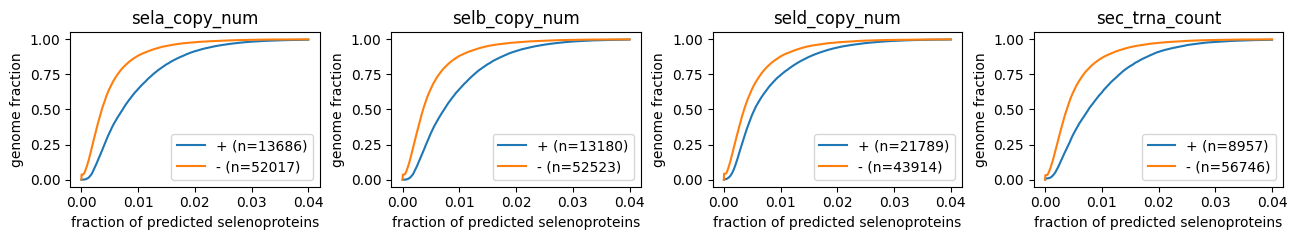

In [56]:
# Want to plot the ECDF of genomes with and without selA, selB, sectRNA, etc. with fraction of predicted selenoproteins on the x-axis. 

def plot_ecdf(sec_fractions_df:pd.DataFrame, ax:plt.Axes=None, max_x_value:float=None):
    # First get the ratios of predicted selenoproteins to total genes for each genome. 
    sec_fractions = sec_fractions_df.sec_fraction.values
    # Sort the genome IDs and selenoprotein fractions in increasing order. 
    # sec_fractions = np.sort(sec_fractions)
    x_vals = np.linspace(0, max_x_value, 1000)
    n = len(sec_fractions_df)
    y_vals = [np.sum(sec_fractions < x) / n for x in x_vals]
    ax.plot(x_vals, y_vals)

    return sec_fractions


fig, axes = plt.subplots(ncols=4, figsize=(13, 2.5))

sec_fractions_df = sec_fractions_df.fillna(0)
# split_on = 'sela_copy_num'
for split_on, ax in zip(['sela_copy_num', 'selb_copy_num', 'seld_copy_num', 'sec_trna_count'], axes):
    sec_fractions_df_pos = sec_fractions_df[sec_fractions_df[split_on] > 0]
    sec_fractions_df_neg = sec_fractions_df[sec_fractions_df[split_on] < 1]

    print(len(sec_fractions_df_neg) + len(sec_fractions_df_pos))
    # pos_y_vals = plot_ecdf(gtdb_results_df_pos, ax=ax, max_x_value=0.04)
    # neg_y_vals = plot_ecdf(gtdb_results_df_neg, ax=ax, max_x_value=0.04)

    pos_sec_fractions = plot_ecdf(sec_fractions_df_pos, ax=ax, max_x_value=0.04)
    neg_sec_fractions = plot_ecdf(sec_fractions_df_neg, ax=ax, max_x_value=0.04)

    # kstest_result = kstest(pos_y_vals, neg_y_vals)
    # print(f'K-S test p-value for {split_on}:', kstest_result.pvalue)
    mwu_result = mannwhitneyu(pos_sec_fractions, neg_sec_fractions)
    print(f'Mann-Whitney U test p-value for {split_on}:', mwu_result.pvalue)
    print(f'Mann-Whitney U test statistic for {split_on}:', mwu_result.statistic)


    ax.set_title(split_on)
    ax.legend([f'+ (n={len(sec_fractions_df_pos)})', f'- (n={len(sec_fractions_df_neg)})'])
    ax.set_ylabel('genome fraction')
    ax.set_xlabel('fraction of predicted selenoproteins')

plt.tight_layout()
plt.show()


In [59]:
old_gtdb_results_df = pd.read_csv('../results/old_gtdb_predictions.csv')
old_genome_ids = old_gtdb_results_df.genome_id.unique()

print('Number of genomes in old results:', len(old_genome_ids))
print('Number of predicted selenoproteins in old results:', len(old_gtdb_results_df[old_gtdb_results_df.prediction > 0]))


def get_gene_data(gene_ids:List[str], batch_size=100, output_path:str=None):
    # NOTE: As long as the batch size is less than 1000 (which I think is the default page size), should not need to paginate at all. 
    gene_data_df = []
    for batch in tqdm([gene_ids[i * batch_size:(i + 1) * batch_size] for i in range(len(gene_ids) // batch_size + 1)], desc='get_gene_data: Fetching gene data...'):
        query = Query('proteins')
        query.equal_to('gene_id', batch)
        gene_data_df.append(query.get())
    gene_data_df = pd.concat(gene_data_df)
    gene_data_df.set_index('gene_id').to_csv(output_path)
    print(f"get_gene_data: Gene and annotations data written to {output_path}")

# get_gene_data(old_gtdb_results_df.gene_id, output_path='../results/old_gtdb_gene_data.csv')

Number of genomes in old results: 6667
Number of predicted selenoproteins in old results: 174718


In [55]:
# gene_ids = []
# # Fix gene IDs that Josh messed up. 
# for gene_id in old_gtdb_results_df.gene_id:
#     gene_id = gene_id.split('_')
#     right = '_'.join(gene_id[-2:])
#     left = '_'.join(gene_id[:2])
#     gene_ids.append(left + '.' + right)
# old_gtdb_results_df['gene_id'] = gene_ids
# old_gtdb_results_df.set_index('gene_id').to_csv('../results/old_gtdb_predictions.csv')

Number of annotated predicted selenoproteins: 445884


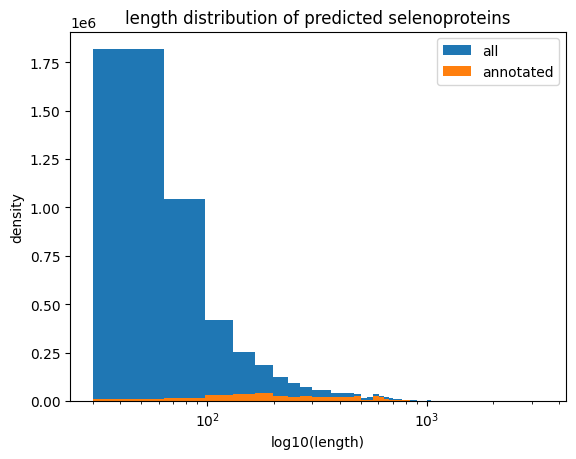

In [63]:
lengths = gtdb_results_df.aa_seq.apply(len)
annotated_lengths = gtdb_results_df[~gtdb_results_df.ko.isnull()].aa_seq.apply(len) 
# old_lengths = pd.read_csv('../results/old_gtdb_gene_data.csv').aa_seq.apply(len)
print('Number of annotated predicted selenoproteins:', len(annotated_lengths))

fig, ax = plt.subplots()
_, bins, _ = ax.hist(lengths, bins=100)
ax.hist(annotated_lengths, bins=bins)
# ax.hist(old_lengths, bins=100, density=True)

# ax.legend(['new results', 'old results'])
ax.legend(['all', 'annotated'])
ax.set_title('length distribution of predicted selenoproteins')

ax.set_ylabel('density')
ax.set_xlabel('log10(length)') # Defaults to base 10. 
ax.set_xscale('log')

plt.show()

In [ ]:
# # Should I normalize by genome size? Seems like if I don't normalize the copy number by genome size, I shouldn't normalize the
# # number of predicted selenoproteins. 

# #MAX_COPY_NUM = 4
# #X_VALS = np.linspace(0, MAX_COPY_NUM, num=100)
# N_BOOTSTRAPS = 50

# def get_copy_num_correlation(gtdb_results_df:pd.DataFrame, gene:str='sela') -> dict:
#     '''Compute the correlation between the copy number of the specified selenoprotein-associated gene and the number of predicted
#     selenoproteins in the genome.'''
#     x, y = [], []

#     for copy_num, df in gtdb_results_df.groupby(f'{gene}_copy_num'): # Group genomes by copy number. 
#         sec_per_genome = df.groupby('genome_id', sort=False).apply(len, include_groups=False).values #  / df.drop_duplicates('genome_id').protein_count.values
#         # y.append(np.mean(sec_per_genome)) # Get the mean number of predicted selenoproteins per genome.
#         # x.append(np.array(copy_num))
#         y += list(sec_per_genome)
#         x += list(np.array([copy_num] * len(sec_per_genome))) # / df.drop_duplicates('genome_id').protein_count.values)
    
#     results = dict()
#     results['x'] = np.array(x)
#     results['y'] = np.array(y)
#     results['spearman_r'] = scipy.stats.spearmanr(x, y).statistic
#     results['pearson_r'] = scipy.stats.pearsonr(x, y).statistic

#     return results


# def bootstrap_copy_num_correlation(gtdb_results_df:pd.DataFrame, n_bootstraps:int=N_BOOTSTRAPS, gene:str='sela', ax:plt.Axes=None) -> Tuple:
#     pearson_r, spearman_r = [], []
#     n = len(gtdb_results_df)

#     def sample(df:pd.DataFrame):
#         '''Sample such that the same number of points from each copy number are randomly-sampled.'''
#         sample_df = []
#         for copy_num, df in df.groupby(f'{gene}_copy_num'):
#             df = df.sample(frac=1, replace=True)
#             df['copy_num'] = copy_num
#             sample_df.append(df)
#         return pd.concat(sample_df)

#     # Do I want to sample from the entire results DataFrame? Or from each individual copy number?

#     for _ in range(n_bootstraps):
#         results = get_copy_num_correlation(sample(gtdb_results_df), gene=gene) 
#         # results = get_copy_num_correlation(gtdb_results_df.sample(frac=1, replace=True))

#         if ax is not None: # Plot the best-fit line, if an axis is provided.
#             x_vals = np.linspace(0, max(results['x']), 100)
#             slope, intercept = np.polyfit(results['x'], results['y'], deg=1) # Get the best fit line for the correlation. 
#             ax.plot(x_vals, x_vals * slope + intercept, c='tab:gray', alpha=0.1)
        
#         pearson_r.append(results['pearson_r'])
#         spearman_r.append(results['spearman_r'])

#     return np.array(pearson_r), np.array(spearman_r)


# def plot_copy_num_correlation(gtdb_results_df:pd.DataFrame, gene:str='sela', ax:plt.Axes=None):

#     results = get_copy_num_correlation(gtdb_results_df, gene=gene)

#     pearson_r, spearman_r = bootstrap_copy_num_correlation(gtdb_results_df, gene=gene, ax=ax, n_bootstraps=N_BOOTSTRAPS)
#     # pearson_p = np.sum(results['pearson_r'] > pearson_r) / N_BOOTSTRAPS
#     # spearman_p = np.sum(results['spearman_r'] > spearman_r) / N_BOOTSTRAPS
#     x_vals = np.linspace(0, max(results['x']), 100)

#     # scatter_x = np.arange(MAX_COPY_NUM)
#     # scatter_y = [np.mean(results['y'][results['x'] == i]) for i in scatter_x]
#     ax.scatter(results['x'], results['y'], c='tab:blue', s=2)

#     slope, intercept = np.polyfit(results['x'], results['y'], deg=1) # Get the best fit line for the correlation. 
#     ax.plot(x_vals, x_vals * slope + intercept, c='tab:blue')

#     conf_low, conf_high = np.round(np.quantile(pearson_r, 0.025), 2), np.round(np.quantile(pearson_r, 0.975), 2)
#     ax.text(0.2, 0.1, 'Pearson\'s R: ' + str(np.round(results['pearson_r'], 2)) + f' (95% conf. {conf_low} to {conf_high})', transform=ax.transAxes, fontsize='x-small')
#     conf_low, conf_high = np.round(np.quantile(spearman_r, 0.025), 2), np.round(np.quantile(spearman_r, 0.975), 2)
#     ax.text(0.2, 0.15,'Spearman\'s R: ' + str(np.round(results['spearman_r'], 2)) + f' (95% conf. {conf_low} to {conf_high})', transform=ax.transAxes, fontsize='x-small')

# fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# for ax, gene in zip(axes, ['selA', 'selB', 'selD']):
#     plot_copy_num_correlation(gtdb_results_df, ax=ax, gene=gene.lower())
#     ax.set_xlabel('copy number')
#     ax.set_ylabel('number of predicted selenoproteins')
#     ax.set_title(gene)

# plt.tight_layout()
# plt.show()